In [1]:
from adversarial_dataset import AdversarialDataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

In [2]:
def show_image(tensor):
    permuted = torch.permute(tensor.cpu(), (1, 2, 0))
    plt.imshow(permuted)

In [3]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model.eval()

# model = models.vgg11(weights=models.VGG11_Weights.DEFAULT)
# model.eval()
dataset = AdversarialDataset(annotation_file="images.csv",
                             categories_file="categories.csv",
                             img_dir="images",
                             noise_dir="adversarial_noise_untargeted",
                             img_transform=img_transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
kpset = pd.read_csv("kppoints.csv")
kpset = kpset[["k", "p", "class", "is_adversarial"]]

In [15]:
from sklearn.utils.extmath import randomized_svd

def find_kp_point(image, model):
    n = image.shape[1]
    input = image[None]
    original_output = model(input)
    _, c_original = torch.max(original_output, dim=1)

    img = np.concatenate([image[0, :, :].numpy(), image[1, :, :].numpy(), image[2, :, :].numpy()], axis=1)
    _, _, WT = randomized_svd(img, n_components=299, random_state=0)
        
    for k in reversed(range(1, n)):
        WT_k = WT[:k, :]
        X_k = img @ WT_k.T @ WT_k

        final_image = np.stack([
            X_k[:, :image.shape[1]],
            X_k[:, image.shape[1]:image.shape[1]*2],
            X_k[:, image.shape[1]*2:]
        ])
        final_image = torch.Tensor(final_image)
        output = model(final_image[None])
        _, c = torch.max(output, dim=1)

        if c != c_original:
            probabilities = torch.nn.functional.softmax(output, dim=1)
            return k, probabilities[0, c].item(), c.item()
        
    print("Oops")
    probabilities = torch.nn.functional.softmax(original_output, dim=1)
    return 1, probabilities[0, c_original].item(), c_original.item()

In [90]:
# RUN TO RESET KPPOINTS FILE
# kpset = pd.DataFrame(np.zeros((2*len(dataset), 4)), columns=["k", "p", "class", "is_adversarial"])
# kpset.to_csv("kppoints.csv")

In [21]:
subset_length = len(dataset)

for i in tqdm(range(0, 2*subset_length)):
    if kpset.loc[i, "k"] == 0 and i != 228 and i != 958 and i != 1958:
        row = dataset[i%subset_length]
    
        img = row[0]
        noise = row[1]
    
        is_adv = i - subset_length >= 0
        if is_adv:
            img = img+noise
            
        k, p, c = find_kp_point(img, model)
        print(f"{i}: Point: ({k}, {p}). Class: {c}. Adv: {is_adv}")
    
        kpset.iloc[i] = [k, p, c, is_adv]
        kpset.to_csv("kppoints.csv")

  0%|          | 0/2000 [00:00<?, ?it/s]

In [22]:
kpset

,k,p,class,is_adversarial
0,45.0,0.468279,302.0,0.0
1,16.0,0.516175,904.0,0.0
2,28.0,0.441809,159.0,0.0
3,48.0,0.335397,532.0,0.0
4,12.0,0.051913,399.0,0.0
...,...,...,...,...
1995,222.0,0.303630,526.0,1.0
1996,255.0,0.380603,703.0,1.0
1997,245.0,0.334562,468.0,1.0
1998,223.0,0.352422,562.0,1.0


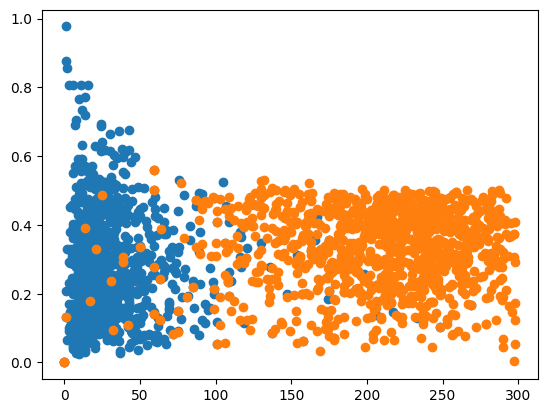

In [24]:
plt.scatter(kpset.loc[:1000, "k"], kpset.loc[:1000, "p"])
plt.scatter(kpset.loc[1000:, "k"], kpset.loc[1000:, "p"])

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay

x_train, x_test, y_train, y_test = train_test_split(kpset[["k", "p", "class"]],
                                                    kpset["is_adversarial"],
                                                    stratify=df["is_adversarial"],
                                                    test_size=.2,
                                                    shuffle=True)

clf = LogisticRegression(random_state=0).fit(x_train[["k", "p"]], y_train)

C:\Users\koend\AppData\Local\Temp\ipykernel_10376\2470142319.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  disp.ax_.scatter(x_train["k"][y_train == 0], x_train["p"][y_train == 0], cmap="bwr", edgecolor="k", label="Benign")
C:\Users\koend\AppData\Local\Temp\ipykernel_10376\2470142319.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  disp.ax_.scatter(x_train["k"][y_train == 1], x_train["p"][y_train == 1], cmap="bwr", edgecolor="k", label="Adversarial")


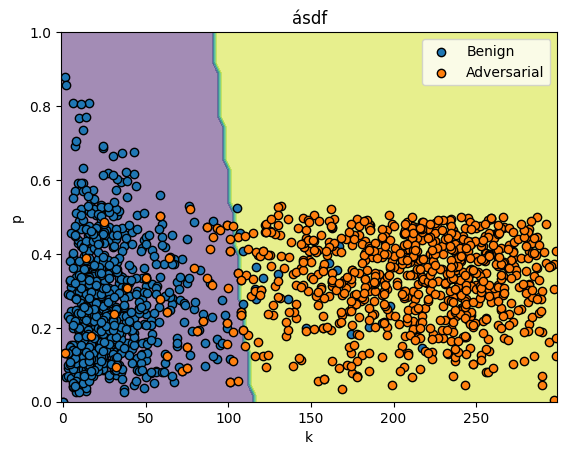

In [32]:
disp = DecisionBoundaryDisplay.from_estimator(clf, x_train[["k", "p"]], response_method="predict", xlabel="k", ylabel="p", alpha=.5)
disp.ax_.set_title('ásdf')
disp.ax_.scatter(x_train["k"][y_train == 0], x_train["p"][y_train == 0], cmap="bwr", edgecolor="k", label="Benign")
disp.ax_.scatter(x_train["k"][y_train == 1], x_train["p"][y_train == 1], cmap="bwr", edgecolor="k", label="Adversarial")
# plt.set_cmap("brg")
# disp.ax_.scatter(x_train.iloc[:, 0], x_train.iloc[:, 1], c=y_train, edgecolor="k")
plt.ylim(0, 1)
plt.legend()

In [67]:
preds = clf.predict(x_test)

In [111]:
type(preds)

numpy.ndarray

In [71]:
preds = clf.predict(x_test[["x", "y"]])

final_predictions = []
real_predictions = []
for i in range(len(x_test)):
    org_idx = x_test.iloc[i].name
    image, noise, label, _, _ = dataset[org_idx % 1000]

    real_predictions.append(label)

    if preds[i]:
        final_predictions.append(x_test.iloc[i]["class"])
    else:
        if org_idx >= 1000:
            image = image + noise
        temp_output = model(image[None])
        _, c = torch.max(temp_output, dim=1)
        final_predictions.append(c)


In [72]:
corr = 0

for i in range(len(final_predictions)):
    eq = final_predictions[i] == real_predictions[i]

    if eq: corr+=1

In [73]:
corr

331

In [74]:
len(final_predictions)

400